## 3.1线性回归

### 正态分布与平方损失

In [1]:
import torch
import numpy as np

In [2]:
%matplotlib inline


In [9]:
import math 
from d2l import torch as d2l

In [13]:
import random

In [4]:
def normal(x,mu,sigma):
    p=1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5/sigma**2*(x-mu)**2)

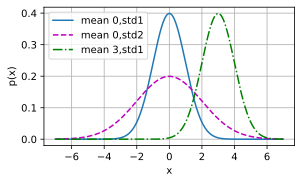

In [10]:
x=np.arange(-7,7,0.01)

params=[(0,1),(0,2),(3,1)]
d2l.plot(x,[normal(x,mu,sigma) for mu,sigma in params],xlabel='x',
         ylabel='p(x)',figsize=(4.5,2.5),
         legend=[f'mean {mu},std{sigma}' for mu,sigma in params],)

为什么用平方损失:<br>
- 假设噪声服从正态分布,有$y=\boldsymbol w^T \boldsymbol x +b+\epsilon$,其中,$\epsilon \sim N(0,\sigma^2)$.
- 则对于给定的$\boldsymbol x$我们可以得到y的似然:$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$
- 最小化负对数似然,可得$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$
- 假设标准差$\sigma$是某个固定的常数,可以发现需要优化的部分就和均方误差差了一个分母常数.

## 3.2线性回归的从0开始实现

### **3.2.1 generate**

In [12]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)

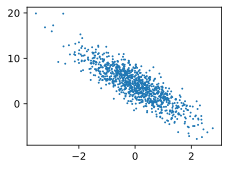

In [15]:
#view
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1);

### **3.2.2 读取数据**

随机梯度下降,则需要一个函数实现对样本抽样.

In [17]:
def data_iter(batch_size,featrues,labels):
    '''
    batch_size: size of son data
    features: X
    labels:y
    '''
    total=len(features)
    number=list(range(total))
    random.shuffle(number)

    for i in range(0,total,batch_size):
        batch_indices=torch.tensor(
            number[i:min(i+batch_size,total)])  # 从打乱的序号选出长度为batch_size的
        yield features[batch_indices],labels[batch_indices] #根据一个序列来索引; 使用生成器,省内存

In [18]:
batch_size=10
groups=data_iter(batch_size,features,labels)

In [19]:
for feature,label in groups:
    print(f'{feature}\n{label}')
    break

tensor([[-2.2953, -0.1015],
        [ 1.2387,  0.4202],
        [-0.4954, -0.2205],
        [-0.5700,  1.3248],
        [ 0.0218,  0.1384],
        [ 0.1885, -0.5553],
        [-1.3757, -1.5840],
        [ 0.4818,  1.0214],
        [ 0.2390, -0.2600],
        [ 0.7104,  0.7088]])
tensor([[-0.0443],
        [ 5.2649],
        [ 3.9534],
        [-1.4451],
        [ 3.7587],
        [ 6.4607],
        [ 6.8303],
        [ 1.6860],
        [ 5.5672],
        [ 3.2232]])


当然,这只是教学.上面这个例子要求将所有数据加载到内存,并执行大量随机内存访问.<br>

深度学习框架中实现的内置迭代器则是处理文件中的数据/数据流

### **3.2.3. 初始化模型参数**

In [20]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
#利用自动微分

### **3.2.4 定义模型**

In [26]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b #broadcast, Vector and a number(b)

### **3.2.5 定义损失函数**

In [22]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2  #look out the shape    in case of bug

### **3.2.6 定义优化算法**
就是对w或者b做随机梯度下降的算法

In [143]:
def sgd(params,lr,batch_size):
    '''
    params: w and b
    lr: learning rate
    batch_size: size of son
    '''
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size  # /batch_size 实现归一化,防止因随机挑选的数量的不同产生干扰
            #可变对象的`-=`实现了就地修改
            param.grad.zero_()
            

`with torch.no_grad()` 是 PyTorch 中的一个上下文管理器，用于禁用梯度计算。在这个上下文块中执行的操作不会被自动微分系统追踪，也不会计算梯度。

主要作用：
1. 节省内存和计算资源
梯度计算需要保存中间结果，禁用梯度计算可以：
- 减少显存占用
- 提高计算速度

2. 避免不必要的梯度计算
在以下场景中不需要梯度：
- 模型推理/预测：只需要前向传播结果
- 参数更新：手动更新参数时（如你的代码示例）
- 评估阶段：测试或验证时

### **3.2.7 训练**

在每次迭代中,我们
- 读取小批量训练样本,
- 并通过我们的模型获得一组预测.
- 计算完损失后,我们开始反向传播,存储每个参数的梯度.
- 最后,我们调研优化算法来更新模型参数.

对于设置超参数,很棘手,需要反复实验,暂时忽略,见11章

In [109]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

In [94]:
w=torch.zeros((2,1),requires_grad=True) 
w
#在创建的时候要注意不能多别的步骤,
    ##eg:w=torch.zeros(2,requires_grad=True).reshape(2,1) ,这里reshape会影响梯度.
#应当检查,正确情况下后面是 requires_grad=True

tensor([[0.],
        [0.]], requires_grad=True)

In [118]:
lr=0.03
num_epochs=3  #轮数
net=linreg
loss=squared_loss

In [119]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y) #l的形状是(batch_size,1)而不是标量
        l.sum().backward() #求和,然后计算关于[w,b]的梯度
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

epoch 1,loss 0.000050
epoch 2,loss 0.000050
epoch 3,loss 0.000050


In [120]:
w,b

(tensor([[ 2.0006],
         [-3.4004]], requires_grad=True),
 tensor([4.1999], requires_grad=True))

In [121]:
true_w

tensor([ 2.0000, -3.4000])

In [122]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0006,  0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)


## 3.3线性回归的简洁实现

### 生成数据集,这里借用了d2l中写好的函数(前面也有)

In [155]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 读取数据集

In [412]:
def load_array(data_arrays,batch_size,is_train=True):
    '''
    data_arrays: X
    batch_size:一批/一群
    is_train: 是否希望在每个迭代周期打乱数据
    '''
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter=load_array((features,labels),batch_size)

In [413]:
data_iter

In [414]:
#但是data_iter不是序列或迭代器

In [415]:
#list(data_iter)[0]  --->it's ok
next(iter(data_iter))

[tensor([[ 0.8957, -0.1233],
         [ 0.5893, -3.2716],
         [-0.4032, -2.5530],
         [ 0.0241, -0.1741],
         [-0.3435, -1.1294],
         [ 0.0969, -0.0886],
         [-1.1318, -0.1282],
         [ 1.1161, -0.8632],
         [ 0.1224, -0.4380],
         [ 0.5822, -1.0464]]),
 tensor([[ 6.4029],
         [16.5024],
         [12.0880],
         [ 4.8391],
         [ 7.3391],
         [ 4.6943],
         [ 2.3807],
         [ 9.3820],
         [ 5.9290],
         [ 8.9152]])]

### 定义模型


对于标准深度学习模型，我们可以使用框架的预定义好的层。

我们首先定义一个**模型变量net**，它是一个**Sequential类的实例**.
- Sequential类将多个层串联在一起。
- 当给定输入数据时，Sequential实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，
- 以此类推。

*在下面的例子中，我们的模型只包含一个层，因此实际上不需要Sequential。但是由于以后几乎所有的模型都是多层的，在这里使用Sequential会让你熟悉“标准的流水线”。*

在PyTorch中，全连接层在Linear类中定义。

值得注意的是，我们将两个参数传递到nn.Linear中。
- 第一个指定输入特征形状，即2，
- 第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [416]:
from torch import nn #neural network

net=nn.Sequential(nn.Linear(2,1))

### 初始化模型参数

In [417]:
# net 就是"模型",储存着结构的相关信息
#实际上在上一步给出输入输出后此时net已经有参数了,不过我们可以也手动设置
net[0].weight.data.normal_(0,0.01)

tensor([[0.0063, 0.0106]])

In [418]:
net[0].weight.data

tensor([[0.0063, 0.0106]])

In [419]:
net[0].bias.data.fill_(0)

tensor([0.])

事实上,这里直接赋值也行
```python
net[0].weight.data=torch.tensor([[0.,0.]])
```

### 定义损失函数

In [420]:
loss = nn.MSELoss(reduction='mean')  
#采用mean时受前面batch_size的影响小,而且误差可以迅速降下来.
#而采用sum时受batch_size的影响很大,会飚到inf.  此时要么减小学习率,要么减小batch_size(每一次随机抽取的样本)

### 定义优化算法
小批量随机梯度下降算法是一种优化神经网络的标准工具,PyTorch在optim模块实现了该算法的许多变种.

实例化一个实例时,需要指定<mark>优化的参数</mark> *(通过net.parameters()从模型中获得)* 以及优化算法所需的<mark>超参数</mark>字典

In [421]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练
训练的过程和前面从0开始类似

In [422]:
num_epochs = 9
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)#通过调用net(X)生成预测并计算损失l（前向传播）
        #trainer.zero_grad()
        l.backward() #通过进行反向传播来计算梯度。
        trainer.step() #通过调用优化器来更新模型参数
        trainer.zero_grad() #将梯度清0,否则反向传播计算梯度默认叠加

    #为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000168
epoch 2, loss 0.000102
epoch 3, loss 0.000102
epoch 4, loss 0.000103
epoch 5, loss 0.000104
epoch 6, loss 0.000103
epoch 7, loss 0.000104
epoch 8, loss 0.000102
epoch 9, loss 0.000102


我们比较生成数据集的真实参数和通过有限数据训练获得的模型参数

In [423]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)


w的估计误差： tensor([-0.0005,  0.0002])
b的估计误差： tensor([-0.0004])


- 我们可以使用PyTorch的高级API更简洁地实现模型。
- 在PyTorch中，data模块提供了数据处理工具，nn模块定义了大量的神经网络层和常见损失函数。
- 我们可以通过`_`结尾的方法将参数替换，从而初始化参数。



In [427]:
# net 就是"模型",储存着结构的相关信息
#实际上在上一步给出输入输出后此时net已经有参数了,不过我们可以也手动设置
net[0].weight.data.normal_(0,0.01)

net[0].bias.data.fill_(0)

loss = nn.MSELoss(reduction='sum')  
#采用mean时受前面batch_size的影响小,
#而采用sum时受batch_size的影响很大. 此时要么减小学习率,要么减小batch_size(每一次随机抽取的样本)


trainer = torch.optim.SGD(net.parameters(), lr=0.01)

num_epochs = 9
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)#通过调用net(X)生成预测并计算损失l（前向传播）
        #trainer.zero_grad()
        l.backward() #通过进行反向传播来计算梯度。
        trainer.step() #通过调用优化器来更新模型参数
        trainer.zero_grad() #将梯度清0,否则反向传播计算梯度默认叠加

    #为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)


epoch 1, loss 0.104310
epoch 2, loss 0.103143
epoch 3, loss 0.105850
epoch 4, loss 0.107093
epoch 5, loss 0.120394
epoch 6, loss 0.104066
epoch 7, loss 0.105725
epoch 8, loss 0.106213
epoch 9, loss 0.112098
w的估计误差： tensor([-0.0006, -0.0008])
b的估计误差： tensor([0.0027])


## 3.4 softmax回归

### 3.4.1分类问题

softmax处理分类问题.标签为**独热编码** eg: $y=\{0,1,0\}$

向量表示为: $\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$

单隐层,全连接.<br>
若有d个输入和q个输出,则参数开销为$O(dq)$.幸运的是,我们可以指定超参数n,将成本降低到$O(dq/n)$.<br>
在参数节省和模型有效性之间权衡.

### 3.4.2 softmax运算

我们需要将输出转换成属于各个类别的概率.<br>
对输出$\{o_1,o_2,...,o_i\}$,有
$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$$
这样可以确保输出的结果是概率

在实际运算中,是对矩阵$\mathbf{O}$每个元素用`exp`,然后除以每一行元素的和

In [16]:
import numpy as np

arr=np.array([[1,2,0.5],[1.1,0.3,-0.8]])

arre=np.exp(arr)
arre/arre.sum(axis=1,keepdims=True)

array([[0.2312239 , 0.62853172, 0.14024438],
       [0.62543093, 0.28102423, 0.09354484]])

### 3.4.3 损失函数


*注: $log$ 实际上是 $ln$ ,以 $e$ 为底数*

#### 1.对数似然

假设整个数据集有 $n$ 个样本,$y$ 是长度为 $q$ 的独热编码向量

似然:$$P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).$$
最小化负对数似然:$$-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),$$
损失函数为*交叉熵损失(cross-entropy loss)*:$$l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j.$$

----

#### 2.softmax及其导数

将softmax得到的$\hat y$代入损失函数,得到:
$$\begin{split}\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}\end{split}$$
对$o_j$求导,得:$$\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.$$
可以看到,导数是我们softmax模型分配的概率与实际发生的情况（由独热标签向量表示）之间的差异.
   

在任何指数族分布模型中（参见本书附录中关于数学分布的一节），对数似然的梯度正是由此得出的。

### 3.4.4信息论基础

...见[[线性神经网络]]

## 3.5图像分类数据集

MNIST数据集是图像分类中广泛使用的数据集之一,但作为基准数据集过于简单.我们使用类似但更复杂的Fashion-MNIST数据集

In [4]:
import torch 
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [5]:
%matplotlib inline 
d2l.use_svg_display()

In [6]:
# read data set
trans=transforms.ToTensor() #ToTensor实例将图像数据从PIL类型变换成32位浮点数,并除以255归一化
mnist_train=torchvision.datasets.FashionMNIST(
    root="./data",train=True,transform=trans,download=True)
mnist_test=torchvision.datasets.FashionMNIST(
    root="./data",train=False,transform=trans,download=True)

In [7]:
len(mnist_train),len(mnist_test),

(60000, 10000)

In [8]:
mnist_train[0][0].shape,mnist_train[0][1]
#可以看到这里每个图片都是 28像素*28像素

# mnist_train[0] 是一个样本,用元组表示的

(torch.Size([1, 28, 28]), 9)

In [9]:
type(mnist_test)
# mnist_test中只有索引一个元素时可以作为python对象

torchvision.datasets.mnist.FashionMNIST

Fashion-MNIST中包含十个类别.

In [10]:
#将数字标记转换成文本名称
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]  #why use 'for' and  'int(i)' ??
    

In [11]:
# 可视化样本
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

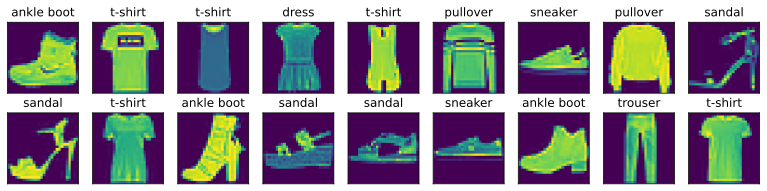

In [12]:
X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))  # choose batch
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y)); # 2*9

In [13]:
#使用内置的数据迭代器读取数据集,且可以打乱.
# 多进程
batch_size=256

def get_dataloader_workers():
    '''use 4 workers to load data'''
    return 4
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,
                           num_workers=get_dataloader_workers())
#进程的数量需要权衡,创建进程需要时间

In [14]:
timer=d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop():.6f} sec'

'0.583559 sec'

In [15]:
#我们将前面的进行整合
def load_data_fashion_mnist(batch_size, resize=None):  #resize可以改变图像的大小
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


## 3.6 softmax回归的从0开始实现

In [16]:
import torch 
from IPython import display
from d2l import torch as d2l


In [17]:
batch_size=256
train_iter,test_iter=load_data_fashion_mnist(batch_size)

In [83]:
#initial

num_inputs=784
num_outputs=10

W=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)
#暂时我们简化处理,将28*28展平为784 
#所以就是输入为784,输出为10

In [22]:
#softmax

def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition

#注:这里没有很好地防止上溢和下溢问题


In [24]:
#define module

def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)
#reshape((-1,W.shape[0])) 第二维长784,第一维自动补

In [44]:
#define loss

In [40]:
#若y是独热编码,直接索引==1:
y=torch.tensor([[0,1,0],[0,0,1]])
y_hat=torch.tensor([[0.2,0.4,0.4],[0.3,0.6,0.1]])
y_hat[y==1]

tensor([0.4000, 0.1000])

In [49]:
#若y是标签,作为索引来选
y=torch.tensor([1,2])
y_hat=torch.tensor([[0.2,0.4,0.4],[0.3,0.6,0.1]])
y_hat[[0,1],y]

tensor([0.4000, 0.1000])

In [50]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y)),y])
## y=1 or 0

cross_entropy(y_hat,y)

tensor([0.9163, 2.3026])

In [51]:
#分类精度

## argmax获取y_hat每行最大概率的索引,与y比较
def accuracy(y_hat,y):
    '''calculate accuracy'''
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y
    return float(cmp.type(y.dtype).sum())

In [52]:
y,y_hat

(tensor([1, 2]),
 tensor([[0.2000, 0.4000, 0.4000],
         [0.3000, 0.6000, 0.1000]]))

In [56]:
accuracy(y_hat,y)/len(y)

0.5

In [67]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) #!
    return metric[0] / metric[1]

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


```python
metric = Accumulator(2)
metric.add(accuracy(net(X), y), y.numel()) 

def add(self, *args):
        self.data = [a + float(b) for a, b in 
                     zip(self.data, args)]
```
- 给`zip`传了两个参数,**准确率**和**总数**.`self.data`是类中定义的列表.
- `zip`将这两个和`self.data`打包成`((self.data[0],accuracy),(self.data[1],total_number))`;
- 在列表推导式则是中先迭代出来,然后拆包给a,b,将`a+float(b)`存入列表. 所以得到的列表第一个元素是准确率之和,第二个元素是总数之和

注:torch.numel?? zip??
- `y.numel()` 获取y中的总数字元素的个数 *(Returns the total number of elements in the :attr:`input` tensor.)*
- `zip` Yield tuples until an input is exhausted.

又注:这里y.numel()是256

In [68]:
evaluate_accuracy(net, test_iter) 
#这是最开始,因为我们随机初始化的权重,所以结果应该接近随机猜测

0.086

In [69]:
# train

首先，我们定义一个函数来训练一个迭代周期。

请注意，updater是更新模型参数的常用函数，它接受批量大小作为参数。它可以是d2l.sgd函数，也可以是框架的内置优化函数。

In [70]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序Animator，
它能够简化本书其余部分的代码。

In [71]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


接下来我们实现一个训练函数，<br>
它会在train_iter访问到的训练数据集上训练一个模型net。该训练函数将会运行多个迭代周期（由num_epochs指定）。<br>
在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估。

我们将利用Animator类来可视化训练进度。

In [82]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    
    print(f'train acc:{train_acc:.6f}\ntest acc:{test_acc:.6f}')
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


以
```python
assert train_loss < 0.5, train_loss
```
为例说明`assert`:

- 检查条件：训练损失是否小于 0.5
- 如果不满足：抛出 AssertionError，并显示当前的 train_loss 值
- 目的：验证训练是否达到了基本效果（损失足够低）

作为一个从零开始的实现，我们使用 3.2节中定义的小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。

In [73]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

现在，我们训练模型10个迭代周期。

请注意，迭代周期（num_epochs）和学习率（lr）都是可调节的超参数。通过更改它们的值，我们可以提高模型的分类精度。

train acc:0.848333
test acc:0.814300


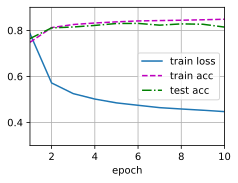

In [84]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


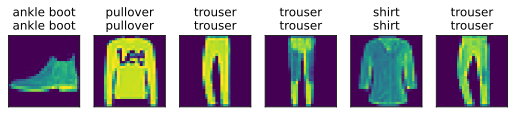

In [86]:
#prediction
def predict_ch3(net, test_iter, n=6):  #@save
    """
    预测标签（定义见第3章）
    y: up
    y_hat:down    
    """
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)


小结:
- 训练softmax回归循环模型与训练线性回归模型非常相似：先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。大多数常见的深度学习模型都有类似的训练过程。

In [87]:
#practice..